<a href="https://colab.research.google.com/github/AsadiAhmad/Face-Swap/blob/main/Code/Face_Swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [2]:
import numpy as np
import cv2 as cv
import dlib
import matplotlib.pyplot as plt

# Step 2: Download Resources

In [3]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2

--2025-05-07 09:47:39--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-05-07 09:47:39--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  13.1MB/s    in 5.9s    

2025-05-07 09:47:46 (10.4 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [4]:
!wget https://raw.githubusercontent.com/AsadiAhmad/Face-Swap/main/Pictures/jensen_huang.jpg -O jensen_huang.jpg
!wget https://raw.githubusercontent.com/AsadiAhmad/Face-Swap/main/Pictures/elon_musk.jpg -O elon_musk.jpg

--2025-05-07 09:47:46--  https://raw.githubusercontent.com/AsadiAhmad/Face-Swap/main/Pictures/jensen_huang.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126823 (124K) [image/jpeg]
Saving to: ‘jensen_huang.jpg’

jensen_huang.jpg    100%[===================>] 123.85K  --.-KB/s    in 0.1s    

2025-05-07 09:47:47 (1.03 MB/s) - ‘jensen_huang.jpg’ saved [126823/126823]

--2025-05-07 09:47:47--  https://raw.githubusercontent.com/AsadiAhmad/Face-Swap/main/Pictures/elon_musk.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31340 

# Step 3: Extract .bz2

In [5]:
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2

# Step 4: Load Images

In [6]:
jensen_huang = cv.imread('jensen_huang.jpg')
elon_musk = cv.imread('elon_musk.jpg')

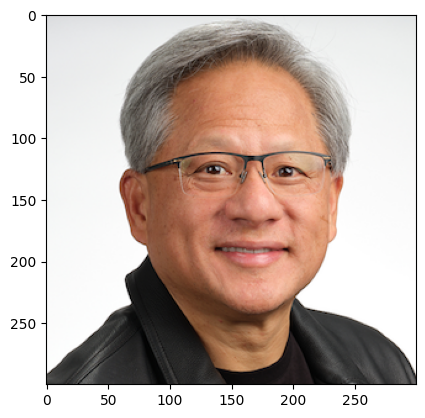

In [7]:
plt.imshow(jensen_huang[...,::-1])

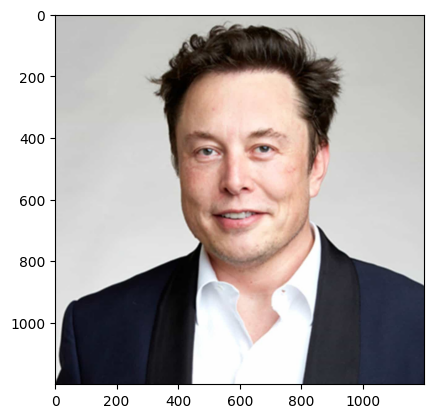

In [8]:
plt.imshow(elon_musk[...,::-1])

# Step 5: Grayscale Images

In [9]:
jensen_huang_gray = cv.cvtColor(jensen_huang, cv.COLOR_BGR2GRAY)
elon_musk_gray = cv.cvtColor(elon_musk, cv.COLOR_BGR2GRAY)

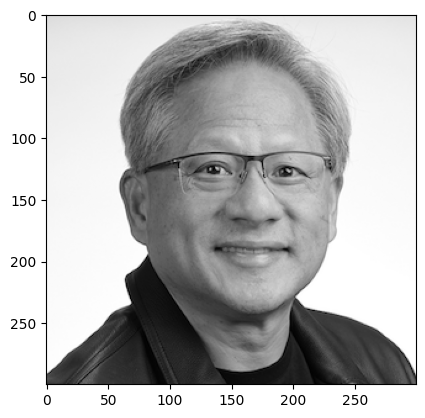

In [10]:
plt.imshow(jensen_huang_gray, cmap='gray')

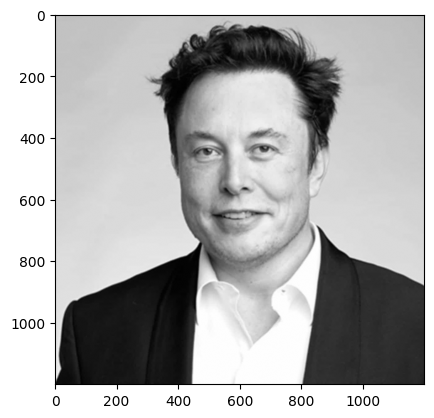

In [11]:
plt.imshow(elon_musk_gray, cmap='gray')

# Step 6: Load face detector

In [12]:
face_detector = dlib.get_frontal_face_detector()

# Step 7: Facial Landmark Predictor

In [13]:
landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Step 8: Detecting Faces

In [14]:
def detect_faces(grayscale):
    faces = face_detector(grayscale)
    return faces

In [15]:
jensen_huang_faces = detect_faces(jensen_huang_gray)
elon_musk_faces = detect_faces(elon_musk_gray)

# Step 9: Extract Facial Landmark

In [24]:
def extract_facial_landmark(image, grayscale, faces):
    facial_landmark = image.copy()

    for face in faces:
        landmarks = landmark_predictor(grayscale, face)
        points = np.array([[p.x, p.y] for p in landmarks.parts()])

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv.circle(facial_landmark, (x, y), 5, (0, 255, 0), -1)
    return points, facial_landmark

In [25]:
jensen_huang_landmarks, jensen_huang_facial_landmark = extract_facial_landmark(jensen_huang, jensen_huang_gray, jensen_huang_faces)
elon_musk_landmarks, elon_musk_facial_landmark = extract_facial_landmark(elon_musk, elon_musk_gray, elon_musk_faces)

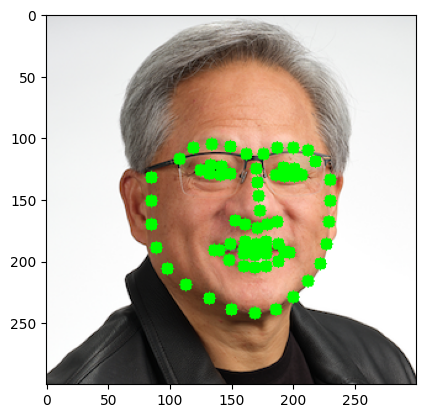

In [26]:
plt.imshow(jensen_huang_facial_landmark[...,::-1])

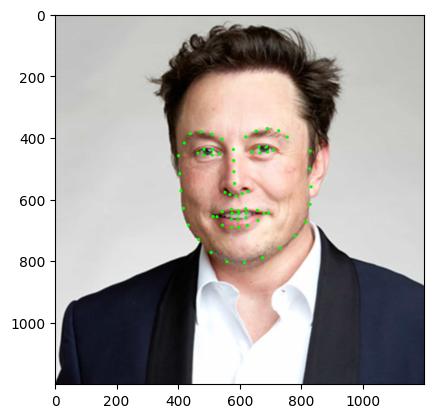

In [27]:
plt.imshow(elon_musk_facial_landmark[...,::-1])

# Step 10: Find Convex Hull

In [28]:
def find_convex_hull(image, faces, landmarks):
    convex_hull_image = image.copy()
    for face in faces:
        hull_indices = cv.convexHull(landmarks, returnPoints=False)
        hull_points = landmarks[hull_indices[:, 0]]

        cv.polylines(convex_hull_image, [hull_points], isClosed=True, color=(0, 0, 255), thickness=3)
    return convex_hull_image, hull_points

In [29]:
convex_hull_jensen_huang, hull_points_jensen_huang = find_convex_hull(jensen_huang, jensen_huang_faces, jensen_huang_landmarks)
convex_hull_elon_musk, hull_points_elon_musk = find_convex_hull(elon_musk, elon_musk_faces, elon_musk_landmarks)

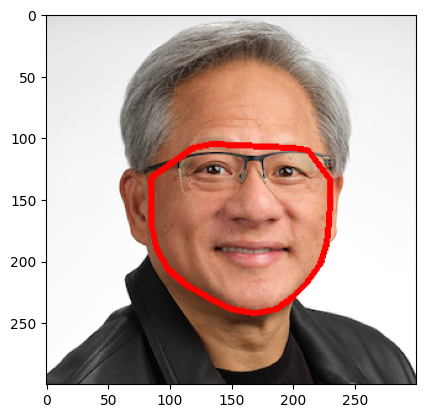

In [30]:
plt.imshow(convex_hull_jensen_huang[...,::-1])

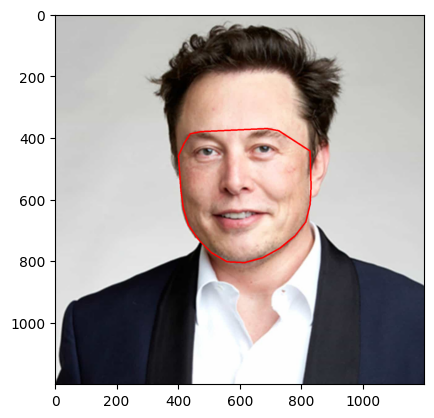

In [31]:
plt.imshow(convex_hull_elon_musk[...,::-1])

# Step 11: Get Delaunay Triangles

In [32]:
def get_delaunay_triangles(rect, points):
    points = np.array(points, dtype=np.float32)

    subdiv = cv.Subdiv2D(rect)
    for p in points:
        subdiv.insert((float(p[0]), float(p[1])))

    triangle_list = subdiv.getTriangleList()
    delaunay_triangles = []

    for t in triangle_list:
        pts = np.array([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]], dtype=np.float32)

        idx = []
        for i in range(3):
            for j, p in enumerate(points):
                if np.linalg.norm(p - pts[i]) < 1.0:  # tolerance
                    idx.append(j)
                    break
        if len(idx) == 3:
            delaunay_triangles.append(tuple(idx))

    return delaunay_triangles


In [35]:
jensen_huang_rect = (0, 0, jensen_huang.shape[1], jensen_huang.shape[0])
elon_musk_rect = (0, 0, elon_musk.shape[1], elon_musk.shape[0])

delaunay_triangles_jensen_huang = get_delaunay_triangles(jensen_huang_rect, jensen_huang_landmarks)
delaunay_triangles_elon_musk = get_delaunay_triangles(elon_musk_rect, elon_musk_landmarks)

# Step 12: Affine warp triangles

In [36]:
def warp_triangle(img1, img2, t1, t2):
    r1 = cv.boundingRect(np.float32([t1]))
    r2 = cv.boundingRect(np.float32([t2]))

    t1_rect = []
    t2_rect = []

    for i in range(3):
        t1_rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2_rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

    mask = np.zeros((r2[3], r2[2], 3), dtype=np.uint8)
    cv.fillConvexPoly(mask, np.int32(t2_rect), (1, 1, 1), 16, 0)

    img1_crop = img1[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
    img1_crop = np.float32(img1_crop)

    mat = cv.getAffineTransform(np.float32(t1_rect), np.float32(t2_rect))
    warped = cv.warpAffine(img1_crop, mat, (r2[2], r2[3]), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT_101)
    warped *= mask
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * (1 - mask) + warped

# Step 13: Sawp Faces

In [37]:
def align_faces(face_image, background_image, delaunay_triangles_background, hull_points_face, hull_points_background):
    warped_image = np.copy(background_image)

    for tri in delaunay_triangles_background:
        if max(tri) >= len(hull_points_face) or max(tri) >= len(hull_points_background):
            continue
        t1 = [hull_points_face[i] for i in tri]
        t2 = [hull_points_background[i] for i in tri]
        warp_triangle(face_image, warped_image, t1, t2)

    return warped_image

In [43]:
swap1 = align_faces(jensen_huang, elon_musk, delaunay_triangles_elon_musk, jensen_huang_landmarks, elon_musk_landmarks)
swap2 = align_faces(elon_musk, jensen_huang, delaunay_triangles_jensen_huang, elon_musk_landmarks, jensen_huang_landmarks)

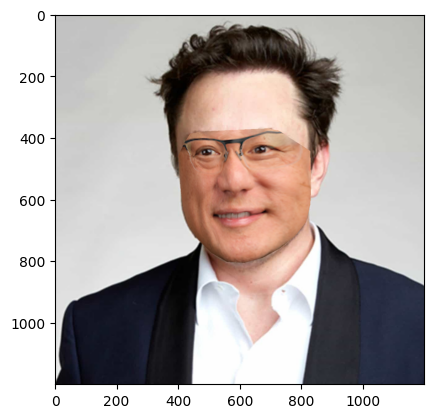

In [46]:
plt.imshow(swap1[...,::-1])

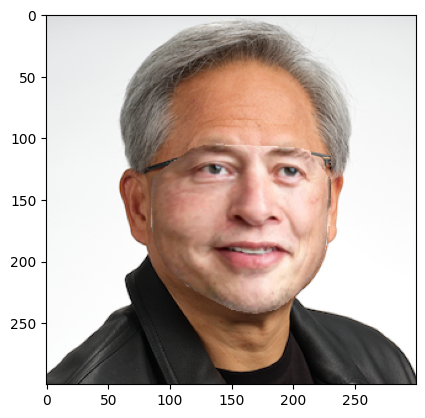

In [45]:
plt.imshow(swap2[...,::-1])

# Step 14: Prepare for Seamless Cloning

In [47]:
def apply_seamless_clone(warped_face, target_image, hull_points):
    mask = np.zeros(target_image.shape, dtype=target_image.dtype)
    cv.fillConvexPoly(mask, cv.convexHull(hull_points), (255, 255, 255))

    r = cv.boundingRect(cv.convexHull(hull_points))
    center_point = (r[0] + r[2] // 2, r[1] + r[3] // 2)

    output = cv.seamlessClone(warped_face, target_image, mask, center_point, cv.NORMAL_CLONE)
    return output

In [64]:
final_swap1 = apply_seamless_clone(swap1, elon_musk, hull_points_elon_musk)
final_swap2 = apply_seamless_clone(swap2, jensen_huang, hull_points_jensen_huang)

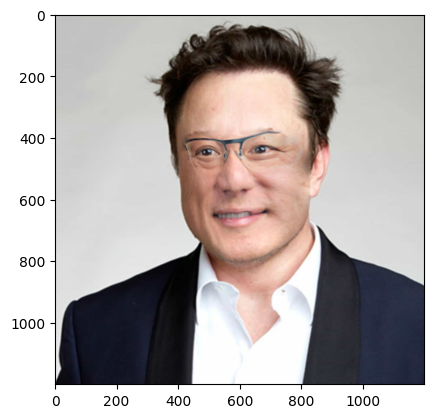

In [65]:
plt.imshow(final_swap1[...,::-1])

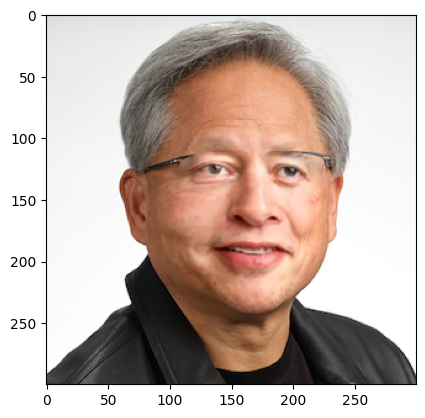

In [66]:
plt.imshow(final_swap2[...,::-1])